# Competitive Pokemon Analysis

While in the traditional pokemon games, players raise Pokemon to complete an adventure, competitive Pokemon is a game where players strategically construct teams of pokemon with moves, natures, items, etc of their choosing to beaet other live players.  Not all Pokemon are equal for this purpose, so based on the usage statistics of the pokemon in competitive play, they are split into various tiers. A player may use a Pokemon to compete in a particular tier if the pokemon is in that tier or below. Historically, usage of various pokemon has changed overtime with the introduction of new pokemon, moves, abilities, and mechanics. So, Pokemon are constantly shifted between tiers to maintain balance.

In this analysis, we will attempt to classify pokemon into the competitive 6v6 tiers based on the properties of the Pokemon themselves.

## Data Processing

In [175]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ggplot import *

%matplotlib inline

AttributeError: 'NoneType' object has no attribute 'name'

In [100]:
df = pd.read_csv('pokemon-data.csv', delimiter=';')
mdf = pd.read_csv('move-data.csv', delimiter=';')

print('Number of pokemon: ', len(df))
df.sample()

Number of pokemon:  918


,Name,Types,Abilities,Tier,HP,Attack,Defense,Special Attack,Special Defense,Speed,Next Evolution(s),Moves
402,Kyurem-Black,"['Dragon', 'Ice']",['Teravolt'],OU,125,170,100,120,90,95,[],"['Icy Wind', 'Dragon Rage', 'Imprison', 'Ancie..."


The base stat total is a common metric players use to assess a Pokemon's overall strength, so let's create a column for this.

In [101]:
df.columns = ['name', 'types', 'abilities', 'tier', 'hp', 'atk', 'def', 'spa', 'spd', 'spe', 'next_evo','moves']
df['bst'] = df['hp'] + df['atk'] + df['def'] + df['spa'] + df['spd'] + df['spe']
df = df[['name', 'types', 'abilities', 'tier', 'hp', 'atk', 'def', 'spa', 'spd', 'spe', 'bst', 'next_evo','moves']]
df.set_index('name', inplace=True)

The next evolution information is not immediately useful; however, we can determine how far a pokemon is in it's evolutionary chain. Notice that a pokemon can have one, two, or three evolutions in it's chain, along with the possibility of a mega evolution. A pokemon that is in its final form that after one evolution is not necessarily weaker or stronger than another after two evolutions. For each pokemon, let's store the length of the evolutionary chain (excluding mega evolutions) and it's stage in the chain. 

A mega evolution will be the stage of the pokemon + 1. For example, Blaziken would have a chain length of 3 and it would be in stage 3, while Mega Blaziken would have a chain length of 3 and it would be in stage 4. 

However, some pokemon have alternate forms listed as evolutions. Consider:

In [164]:
df[df.index == 'Giratina']

,types,abilities,tier,hp,atk,def,spa,spd,spe,bst,next_evo,moves,stage,num_evos
name,,,,,,,,,,,,,,
Giratina,"['Dragon', 'Ghost']","['Pressure', 'Telepathy']",Uber,150,100,120,100,120,90,680,['Giratina-Origin'],"['Dragon Breath', 'Scary Face', 'Ominous Wind'...",1,1


We shall treat alternate forms that have a BST that is strictly greater than its original as a mega evolution. Otherwise, it will be treated as equivalent to the original form.

In [158]:
def stage_in_evo(n):
    # returns number of evolutions before it
    #print(df[df['name'] == n]['name'])
    bool_arr = df.apply(lambda x: n in eval(x['next_evo']) and (n+'-') not in x['next_evo'], axis=1) #gets index of previous evolution
    if '-Mega' in n: #mega evolutions
        return stage_in_evo(n.split('-')[0]) + 1 
    elif not any(bool_arr):
        return 1 # if there's nothing before it, it's the first
    else:
        return 1 + stage_in_evo(df.index[bool_arr][0])

def num_evos(n):
    if n not in df.index: #checks to ensure valid pokemon
        return n
    
    next_evos = eval(df.loc[n, 'next_evo'])
    if len(next_evos) > 0: #existence of next_evo
        if n in next_evos[0]: # if "next evo" is an alternate form
            return df.loc[n, 'stage'] #accounting for alternate forms
        else:
            return num_evos(next_evos[0])
    elif '-Mega' in n or n.split('-')[0] in df.index: 
        #this is checking if there is a pokemon with the same root name (e.g. Shaymin vs Shaymin-Sky)
        return df.loc[n.split('-')[0], 'stage']
    else:
        return df.loc[n, 'stage']

In [159]:
df['stage'] = df.apply(lambda x: stage_in_evo(x.name), axis=1)

In [160]:
df['num_evos'] = df.apply(lambda x: num_evos(x.name), axis=1)

In [161]:
df[(df.index == 'Landorus-Therian') | (df.index == 'Landorus') | (df.index == 'Monferno') | (df.index == 'Blaziken-Mega') | (df.index == 'Diglett-Alola')] #test

,types,abilities,tier,hp,atk,def,spa,spd,spe,bst,next_evo,moves,stage,num_evos
name,,,,,,,,,,,,,,
Blaziken-Mega,"['Fire', 'Fighting']",['Speed Boost'],Uber,80,160,80,130,80,100,630,[],"['Flare Blitz', 'Fire Punch', 'High Jump Kick'...",4,3
Diglett-Alola,"['Ground', 'Steel']","['Sand Force', 'Sand Veil', 'Tangling Hair']",LC,10,55,30,35,45,90,265,['Dugtrio-Alola'],"['Sand Attack', 'Metal Claw', 'Growl', 'Astoni...",1,2
Landorus,"['Flying', 'Ground']","['Sand Force', 'Sheer Force']",Uber,89,125,90,115,80,101,600,['Landorus-Therian'],"['Outrage', 'Hammer Arm', 'Fissure', 'Block', ...",1,1
Landorus-Therian,"['Flying', 'Ground']",['Intimidate'],OU,89,145,90,105,80,91,600,[],"['Outrage', 'Hammer Arm', 'Fissure', 'Block', ...",2,1
Monferno,"['Fighting', 'Fire']","['Blaze', 'Iron Fist']",NaN,64,78,52,78,52,81,405,['Infernape'],"['Scratch', 'Leer', 'Mach Punch', 'Mach Punch'...",2,3


As of generation 7, there are 8 playable tiers. From strongest to weakest: Anything Goes (AG), Uber, Overused (OU), Underused (UU), Rarelyused (RU), Neverused (NU), Partiallyused (PU) and Little Cup (LC). There are also unplayable tiers called borderline tiers, suffixed by BL. These serve as banlists for their respective tiers (so these pokemon can only be used in higher tiers). For the purpose of this analysis, we will classify BL pokemon as the tier above.

We will not consider the Little Cup (LC) format, as they are not defined by usage statistics (it involves pokemon that are not evolved but are capable of evolution and can be obtained in the traditional games at level 5). We will also discard the AG tier, as it was created solely for Mega Rayquaza. Both Pokemon that belong to no tier because they are uncompetitive and pokemon in the Limbo tier becuase they are unreleased will not be considererd.

Let's make these changes. Also, we shall number the tiers to make plotting easier (lower number => better tier)

In [220]:
df.loc[df.tier == 'OUBL','tier'] = 'Uber'
df.loc[df.tier == 'UUBL','tier'] = 'OU'
df.loc[df.tier == 'RUBL','tier'] = 'UU'
df.loc[df.tier == 'NUBL','tier'] = 'RU'
df.loc[df.tier == 'PUBL','tier'] = 'NU'
df = df[df['tier'].isin(['Uber', 'OU', 'UU', 'NU', 'RU', 'PU'])]

In [229]:
mapping = {'Uber': 0, 'OU': 1, 'UU': 2, 'RU': 3, 'NU': 4, 'PU': 5}
df['tier_num'] = df.apply(lambda x: mapping[x['tier']], axis=1)

## Exploratory Data Analysis

Let's explore some of the relationships in this data. First, the distribution of the classes:

Total number of Pokemon:  552


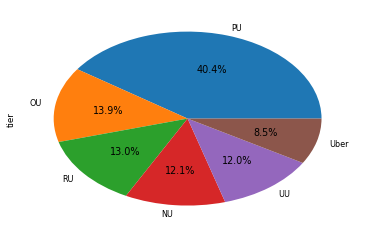

In [380]:
ax = df.tier.value_counts().plot(kind='pie', autopct='%1.1f%%')
print('Total number of Pokemon: ', len(df))

All the upper tiers are similar in size by design, but the PU tier is a dump of all the least used pokemon. We must account for this later. 

Let's examine how the the average stats compare for each tier:

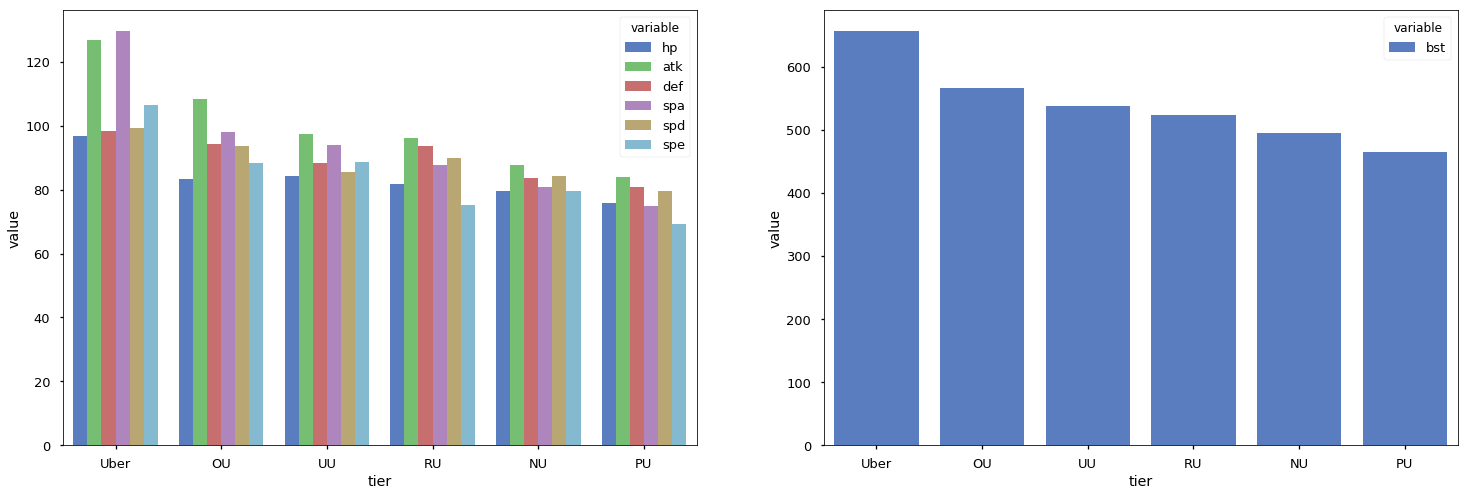

In [381]:
temp = df[['tier', 'tier_num', 'hp', 'atk', 'def', 'spa', 'spd', 'spe', 'bst']].groupby(['tier', 'tier_num']).agg(np.mean)
temp = temp.reset_index()
temp2 = temp.melt(id_vars=['tier', 'tier_num']).sort_values('tier_num', ascending=True)

sns.set_context('talk')
fig, ax = plt.subplots(1,2, figsize=(25,8))
g=sns.factorplot(x="tier", y="value", hue_order=['hp', 'atk', 'def', 'spa', 'spd', 'spe'], hue="variable", data=temp2,
                   kind="bar", palette="muted", aspect=1.5, ax=ax[0])
g2=sns.factorplot(x="tier", y="value", hue_order=['bst'],hue="variable", data=temp2,
                   kind="bar", palette="muted", aspect=1.5,  ax=ax[1])
plt.close(g.fig)
plt.close(g2.fig)

As expected, there is a correlation between how the level of the tier and the pokemon's stats. Interestingly, attack and special attack stats tend to become more prominent in the higher tiers, indicating a more offensive playstyle in these tiers. Also, RU seems to have a lower average speed than NU but higher defensive stats than UU, indicating a particularly defensive playstyle in this tier. 